In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg
from scipy.sparse.linalg import eigs
import cv2
from cv2 import Mat
import math
import random
from IPython.display import Image, display
from PIL import Image as im

In [ ]:
class TransferedPicture: #画像の相似変換
    def __init__(self,pic:Mat,scale,theta):
        self.orig_img=cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
        h,w=self.orig_img.shape
        mat = cv2.getRotationMatrix2D((w / 2, h / 2), theta, scale) #相似変換のパラメータ設定
        self.img = cv2.warpAffine(self.orig_img, mat, (w, h)) #相似変換を実行
        self.scale=scale
        self.theta=theta
    
    def write(self,img_name):
        cv2.imwrite(img_name,self.img)
        
    def get_img_array(self): #オリジナル画像と変換後画像の配列を得る
        return self.orig_img, self.img

    def get_deff_array(self,img,axis=0): #微分画像を得る
        #axis=0: x方向の微分, axis=1: y方向の微分
        h,w=img.shape
        mat=np.zeros([h,w])
        for i in range(1,h-1):
            for j in range(1,w-1):
                if axis==0:
                    mat[i][j]=(img[i][j+1]-img[i][j-1])/2
                elif axis==1:
                    mat[i][j]=(img[i+1][j]-img[i-1][j])/2
        return mat

    def smooth_def(self): #x方向,y方向それぞれの平滑微分画像を生成
        #x方向の平滑微分画像
        gs_x=cv2.GaussianBlur(self.img,(3,3),3)
        dst_x=self.get_deff_array(gs_x,axis=0)
        
        #y方向の微分
        gs_y=cv2.GaussianBlur(self.img,(3,3),3)
        dst_y=self.get_deff_array(gs_y,axis=1)
        
        return dst_x,dst_y

In [9]:
class GaussNewton:
    def __init__(self,orig:np.array,st:np.array,i_x:np.array,i_y:np.array):
        #θとsを初期化
        self.theta=random.uniform(-180,180)*np.pi/180
        self.scale=random.random()
        #各画像配列を保持
        self.orig=orig
        self.st=st
        self.i_x=i_x
        self.i_y=i_y
        self.h,self.w=orig.shape
        
    def dx_dtheta(self,x,y):
        return self.scale*(-2*x*np.sin(self.theta)-(2*y*np.cos(self.theta)))
    def dy_dtheta(self,x,y):
        return self.scale*(2*x*np.cos(self.theta)-(2*y*np.sin(self.theta)))
    def dx_dscale(self,x,y):
        return 2*x*np.cos(self.theta)-(2*y*np.sin(self.theta))
    def dy_dscale(self,x,y):
        return 2*x*np.sin(self.theta)+(2*y*np.cos(self.theta))
    
    #1周分の計算を行う
    def calc_param(self):
        h,w=int(self.h/2),int(self.w/2)
        j_t=j_tt=j_s=j_ss=j_ts=.0
        print("θ={0}, s={1}".format(self.theta,self.scale))
        for i in range(-1*h,h):
            for j in range(-1*w,w):
                #配列の座標を画像の中心を原点とした座標に変換
                x,y=j,-1*i #y軸の正の方向を向かせる
                x_d=int(self.scale*(np.cos(self.theta)*x-(np.sin(self.theta)*y)))
                y_d=int(self.scale*(np.sin(self.theta)*x+(np.cos(self.theta)*y)))
                
                dxdt=self.dx_dtheta(x_d,y_d)
                dydt=self.dy_dtheta(x_d,y_d)
                dxds=self.dx_dscale(x_d,y_d)
                dyds=self.dy_dscale(x_d,y_d)
                
                #配列の座標値に逆変換
                x,y=x+w,-1*y+h
                x_d,y_d=x_d+w-1,-1*y_d+h-1
                if x_d>self.w:
                    print("error",y_d,x_d)
                
                #各微分式の計算
                I_dash=self.st[y_d][x_d]
                I=self.orig[y][x]
                I_dash_x=self.i_x[y_d][x_d]
                I_dash_y=self.i_y[y_d][x_d]

                j_t+=(I_dash-I)*(I_dash_x*dxdt+(I_dash_y*dydt))
                j_tt+=np.square(I_dash_x*dxdt+(I_dash_y*dydt))
                j_s+=(I_dash-I)*(I_dash_x*dxds+(I_dash_y*dyds))
                j_ss+=np.square(I_dash_x*dxds+(I_dash_y*dyds))
                j_ts+=(I_dash_x*dxdt+(I_dash_y*dydt))*(I_dash_x*dxds+(I_dash_y*dyds))
        
        #delta_thetaとdelta_scaleの計算
        mt=np.array([[j_tt,j_ts],[j_ts,j_ss]])
        deltas=-1*np.linalg.pinv(mt).dot(np.array([j_t,j_s]).T)
        print("Δθ={0}, Δs={1}".format(deltas[0],deltas[1]))
        return deltas[0],deltas[1]
    
    def until_convergence(self):
        eps=1e-8
        old_dt=old_ds=1000
        i=1
        while(True):
            print("{0}周目".format(i))
            new_dt,new_ds=self.calc_param()
            self.theta+=new_dt
            self.scale+=new_ds
            if abs(new_dt-old_dt)<eps and abs(new_ds-old_ds)<eps:
                print("収束を確認")
                print("最終値: θ={0}, s={1}".format(self.theta,self.scale))
                break
            i+=1
            old_dt,old_ds=new_dt,new_ds
        pass

In [5]:
def imshow(img):
    #ndarray 配列から画像をNotebook上に表示
    ret, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))

In [10]:
pic_name="pic1.png"
pic_st_name="pic2.png"
#thetaとscaleの初期値を適当に決める
s,t=0.6,20
orig_img=cv2.imread(pic_name)
tp=TransferedPicture(pic=orig_img,scale=s,theta=t)
tp.write(pic_st_name)

#画像データを得る
orig_img,st_img=tp.get_img_array()
orig_array,st_array=np.array(orig_img),np.array(st_img)

#Iの計算
i_x,i_y=tp.smooth_def()
i_x_array,i_y_array=np.array(i_x),np.array(i_y)

/tmp/ipykernel_41747/1172856781.py:23: RuntimeWarning: overflow encountered in ubyte_scalars
  mat[i][j]=(img[i][j+1]-img[i][j-1])/2
/tmp/ipykernel_41747/1172856781.py:25: RuntimeWarning: overflow encountered in ubyte_scalars
  mat[i][j]=(img[i+1][j]-img[i-1][j])/2


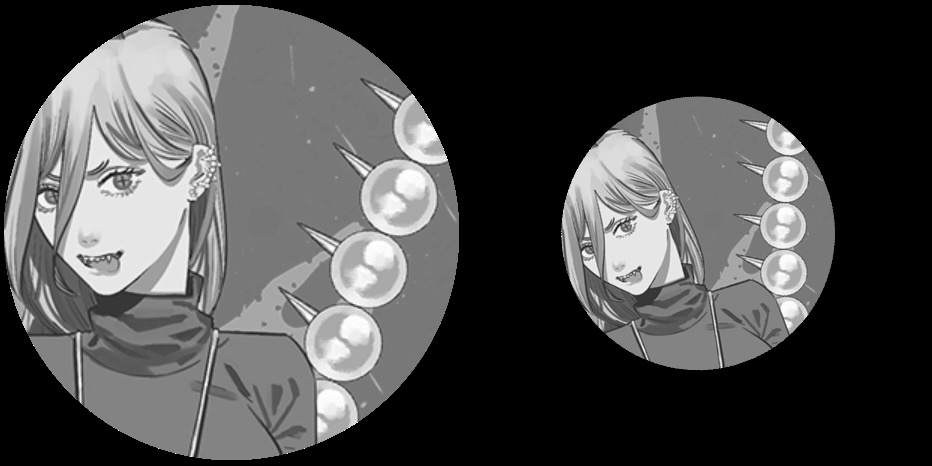

In [11]:
imgs=cv2.hconcat([orig_img,st_img])
imshow(imgs)

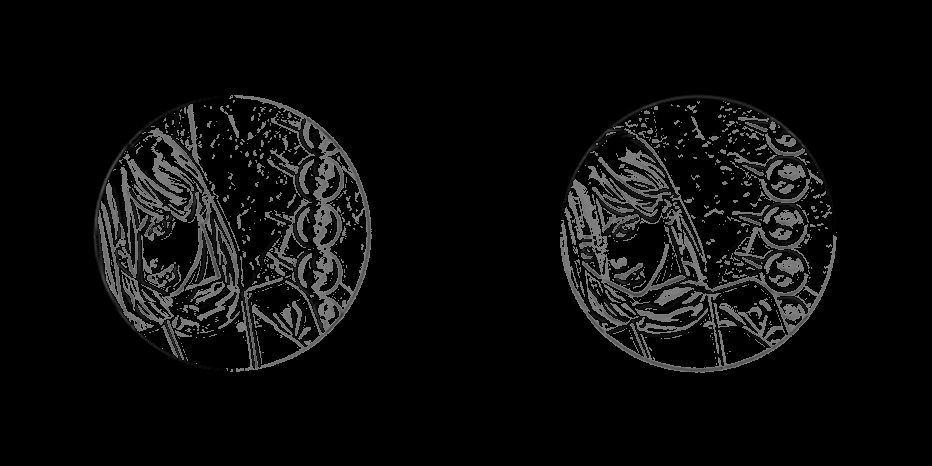

In [12]:
imgs=cv2.hconcat([i_x,i_y])
imshow(imgs)

In [13]:
gn=GaussNewton(orig=orig_array,st=st_array,i_x=i_x_array,i_y=i_y_array)
gn.until_convergence()

1周目
θ=-0.8399629746387369, s=0.33644969878977693


/tmp/ipykernel_41747/4196366268.py:51: RuntimeWarning: overflow encountered in ubyte_scalars
  j_t+=(I_dash-I)*(I_dash_x*dxdt+(I_dash_y*dydt))
/tmp/ipykernel_41747/4196366268.py:53: RuntimeWarning: overflow encountered in ubyte_scalars
  j_s+=(I_dash-I)*(I_dash_x*dxds+(I_dash_y*dyds))


Δθ=0.0008958910835160253, Δs=0.0013032012793345905
2周目
θ=-0.8390670835552209, s=0.3377529000691115
Δθ=0.0009164147881255512, Δs=0.001293977730539694
3周目
θ=-0.8381506687670953, s=0.3390468777996512
Δθ=0.0009328199580169082, Δs=0.0012947269523718172
4周目
θ=-0.8372178488090785, s=0.340341604752023
Δθ=0.0008916233318425859, Δs=0.0012838476358314655
5周目
θ=-0.8363262254772359, s=0.34162545238785447
Δθ=0.0008433539918386938, Δs=0.001272699730754271
6周目
θ=-0.8354828714853972, s=0.34289815211860875
Δθ=0.0007909256643092026, Δs=0.0012584388546233597
7周目
θ=-0.8346919458210881, s=0.3441565909732321
Δθ=0.0007393344724294484, Δs=0.0012662895312721815
8周目
θ=-0.8339526113486586, s=0.34542288050450426
Δθ=0.0007076576983229348, Δs=0.0012579529323767014
9周目
θ=-0.8332449536503357, s=0.34668083343688094
Δθ=0.000687514964469867, Δs=0.00124596878256807
10周目
θ=-0.8325574386858658, s=0.347926802219449
Δθ=0.0006090034099611965, Δs=0.001217913112246301
11周目
θ=-0.8319484352759047, s=0.3491447153316953
Δθ=0.0005757

KeyboardInterrupt: 